In [1]:
!pip install chardet

In [7]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt 
import chardet

In [3]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium 
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap

In [162]:
import matplotlib.colors as mcolors

In [ ]:
import os

In [ ]:
import seaborn as sns

In [4]:
!pip install folium

In [259]:
df = pd.read_csv(r'../data/IPRESS.csv', dtype={"UBIGEO": str}, encoding="latin1")
print(df.head())

         Institución  Código Único Nombre del establecimiento  \
0            PRIVADO         16618                 SONRIE MAS   
1  GOBIERNO REGIONAL          7050                     AMBATO   
2  GOBIERNO REGIONAL            99  SANTA ISABEL DE YUMBATURO   
3            PRIVADO         19555               DENTOCAPLINA   
4               OTRO         18792  MEDICO DE FAMILIA MANTARA   

                                       Clasificación  \
0  CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...   
1                 PUESTOS DE SALUD O POSTAS DE SALUD   
2                 PUESTOS DE SALUD O POSTAS DE SALUD   
3  CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...   
4                 PUESTOS DE SALUD O POSTAS DE SALUD   

                                         Tipo Departamento Provincia  \
0  ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO         LIMA      LIMA   
1  ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO    CAJAMARCA   CUTERVO   
2  ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO       LORE

In [260]:
df_valid_coords = df.dropna(subset=["NORTE", "ESTE"])

print(df_valid_coords.head())
print("Number of records with valid coordinates:", len(df_valid_coords))

          Institución  Código Único         Nombre del establecimiento  \
1   GOBIERNO REGIONAL          7050                             AMBATO   
2   GOBIERNO REGIONAL            99          SANTA ISABEL DE YUMBATURO   
6               MINSA          7278  PUESTO DE SALUD HEROES DEL CENEPA   
12  GOBIERNO REGIONAL          5460                      NUEVA BETANIA   
15  GOBIERNO REGIONAL          6431                         PONGO ISLA   

                         Clasificación  \
1   PUESTOS DE SALUD O POSTAS DE SALUD   
2   PUESTOS DE SALUD O POSTAS DE SALUD   
6   PUESTOS DE SALUD O POSTAS DE SALUD   
12  PUESTOS DE SALUD O POSTAS DE SALUD   
15  PUESTOS DE SALUD O POSTAS DE SALUD   

                                          Tipo Departamento         Provincia  \
1   ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO    CAJAMARCA           CUTERVO   
2   ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO       LORETO            LORETO   
6   ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO         LIMA

In [261]:
print(df["Condición"].unique())  #We check how "Condición" is stored and determine that we need "EN FUNCIONAMIENTO".

['EN FUNCIONAMIENTO' 'INOPERATIVO' 'CIERRE TEMPORAL'
 'RESTRICCIÓN DE SERVICIOS']


In [262]:
df["Condición"] = df["Condición"].str.strip()

df_funcionamiento = df[
    (df["Condición"] == "EN FUNCIONAMIENTO") &
    (df["NORTE"].notna()) &
    (df["ESTE"].notna())
].copy()

print(df_funcionamiento.shape)
print(df_funcionamiento.head())

(7942, 33)
          Institución  Código Único         Nombre del establecimiento  \
1   GOBIERNO REGIONAL          7050                             AMBATO   
2   GOBIERNO REGIONAL            99          SANTA ISABEL DE YUMBATURO   
6               MINSA          7278  PUESTO DE SALUD HEROES DEL CENEPA   
12  GOBIERNO REGIONAL          5460                      NUEVA BETANIA   
15  GOBIERNO REGIONAL          6431                         PONGO ISLA   

                         Clasificación  \
1   PUESTOS DE SALUD O POSTAS DE SALUD   
2   PUESTOS DE SALUD O POSTAS DE SALUD   
6   PUESTOS DE SALUD O POSTAS DE SALUD   
12  PUESTOS DE SALUD O POSTAS DE SALUD   
15  PUESTOS DE SALUD O POSTAS DE SALUD   

                                          Tipo Departamento         Provincia  \
1   ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO    CAJAMARCA           CUTERVO   
2   ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO       LORETO            LORETO   
6   ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO  

Task 1: Static Maps — Hospital Count by District

In [263]:
distritos = gpd.read_file(r'../data/districts/DISTRITOS.shp')  #Import shapefile
print(distritos.head())


  IDDPTO DEPARTAMEN IDPROV    PROVINCIA  IDDIST                DISTRITO  \
0     10    HUANUCO   1009  PUERTO INCA  100902         CODO DEL POZUZO   
1     10    HUANUCO   1009  PUERTO INCA  100904             TOURNAVISTA   
2     25    UCAYALI   2503   PADRE ABAD  250305  ALEXANDER VON HUMBOLDT   
3     25    UCAYALI   2503   PADRE ABAD  250302                 IRAZOLA   
4     25    UCAYALI   2503   PADRE ABAD  250304                 NESHUYA   

                  CAPITAL CODCCPP  AREA FUENTE  \
0         CODO DEL POZUZO    0001     1   INEI   
1             TOURNAVISTA    0001     1   INEI   
2  ALEXANDER VON HUMBOLDT    0001     1   INEI   
3           SAN ALEJANDRO    0001     1   INEI   
4            MONTE ALEGRE    0001     1   INEI   

                                            geometry  
0  POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...  
1  POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...  
2  POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...  
3  POLYGON ((-75.13864 -8.56

In [264]:
distritos = distritos.rename({'IDDIST':'UBIGEO'}, axis =1 )  #Rename IDDIST to UBIGEO so it can be merged later

In [265]:
distritos #We check "distritos"

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,UBIGEO,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...,...,...,...,...,...,...,...,...,...
1868,10,HUANUCO,1006,LEONCIO PRADO,100608,CASTILLO GRANDE,CASTILLO GRANDE,0001,1,INEI,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,10,HUANUCO,1006,LEONCIO PRADO,100609,PUEBLO NUEVO,PUEBLO NUEVO,0001,1,INEI,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,10,HUANUCO,1006,LEONCIO PRADO,100610,SANTO DOMINGO DE ANDA,PACAE,0001,1,INEI,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,21,PUNO,2111,SAN ROMAN,211105,SAN MIGUEL,SAN MIGUEL,0001,1,INEI,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


In [266]:
df_funcionamiento #We check df_funcionamiento.

,Institución,Código Único,Nombre del establecimiento,Clasificación,Tipo,Departamento,Provincia,Distrito,UBIGEO,Dirección,...,Inicio de Actividad,Director Médico y/o Responsable de la Atención de Salud,Estado,Situación,Condición,Inspección,NORTE,ESTE,COTA,CAMAS
1,GOBIERNO REGIONAL,7050,AMBATO,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,CAJAMARCA,CUTERVO,SANTA CRUZ,060611,COMUNIDAD DE AMBATO,...,29/06/2006,IDELSO MENOR CHAVEZ,ACTIVADO,,EN FUNCIONAMIENTO,,-78.858380,-6.133523,1724.0,NaN
2,GOBIERNO REGIONAL,99,SANTA ISABEL DE YUMBATURO,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,LORETO,LORETO,PARINARI,160302,ACTUALIZAR,...,01/01/1900,JULIO TONY CAITIMARI MACHOA,ACTIVADO,,EN FUNCIONAMIENTO,,-74.258139,-4.581509,124.0,NaN
6,MINSA,7278,PUESTO DE SALUD HEROES DEL CENEPA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,LIMA,LIMA,VILLA EL SALVADOR,150142,"JR. HEROES DEL CENEPA MZ C LT 20, ALT DE PANAM...",...,01/02/2008,BASTIDAS CAMARENA HUBERT ALEX . .,ACTIVADO,,EN FUNCIONAMIENTO,,-76.930608,-12.248699,NaN,NaN
12,GOBIERNO REGIONAL,5460,NUEVA BETANIA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,UCAYALI,CORONEL PORTILLO,CALLERIA,250101,OTROS CC.NN. NUEVA BETANIA S/N NÚMERO S/N DIST...,...,20/12/2000,MARIANA VASQUEZ PINEDO,ACTIVADO,,EN FUNCIONAMIENTO,,-74.296531,-8.398366,177.0,NaN
15,GOBIERNO REGIONAL,6431,PONGO ISLA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,SAN MARTIN,SAN MARTIN,HUIMBAYOC,220907,OTROS CP PONGO ISLA DISTRITO HUIMBAYOC PROVINC...,...,14/09/2001,MIRLANDA MOZOMBITE BARDALES,ACTIVADO,,EN FUNCIONAMIENTO,,-75.885812,-6.438298,172.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20814,GOBIERNO REGIONAL,2283,P.S NUEVO HUALAPAMPA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO NUEVO HUALAPAMPA S/N,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.437187,-5.789407,1364.0,NaN
20815,GOBIERNO REGIONAL,2278,P.S SAN MARTIN DE CONGOÑA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO SAN MARTIN DE CONGOÑA S/N,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.627953,-5.644592,1320.0,NaN
20816,GOBIERNO REGIONAL,2274,P.S TUNAS,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO TUNAS,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.546778,-5.498508,1549.0,NaN
20817,GOBIERNO REGIONAL,2272,C.S LIMON DE PORCUYA,CENTROS DE SALUD O CENTROS MEDICOS,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO LIMON DE PORCUYA,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.537903,-5.889830,1612.0,NaN


In [267]:
hospital_counts = df_funcionamiento.groupby("UBIGEO").size().reset_index(name="hospital_count") #We group hospitals by UBIGEO to get the amount
#of hospitals each UBIGEO (district) has.

print(hospital_counts.head())

   UBIGEO  hospital_count
0  010101              28
1  010102               1
2  010103               3
3  010104               1
4  010105               4


In [268]:
hospital_counts #We check the hospital counts.

,UBIGEO,hospital_count
0,010101,28
1,010102,1
2,010103,3
3,010104,1
4,010105,4
...,...,...
1809,250302,7
1810,250303,6
1811,250304,7
1812,250305,2


In [269]:
distritos = distritos.merge(hospital_counts, on="UBIGEO", how="left") #We merge both databases by UBIGEO


In [270]:
distritos #"distritos" now contains all data.

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,UBIGEO,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry,hospital_count
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",3.0
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",4.0
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",2.0
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",7.0
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1868,10,HUANUCO,1006,LEONCIO PRADO,100608,CASTILLO GRANDE,CASTILLO GRANDE,0001,1,INEI,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130...",1.0
1869,10,HUANUCO,1006,LEONCIO PRADO,100609,PUEBLO NUEVO,PUEBLO NUEVO,0001,1,INEI,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010...",1.0
1870,10,HUANUCO,1006,LEONCIO PRADO,100610,SANTO DOMINGO DE ANDA,PACAE,0001,1,INEI,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886...",1.0
1871,21,PUNO,2111,SAN ROMAN,211105,SAN MIGUEL,SAN MIGUEL,0001,1,INEI,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3...",2.0


In [271]:
distritos["hospital_count"] = distritos["hospital_count"].astype("Int64") #We switch to integer for easier visualization.

In [272]:
distritos

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,UBIGEO,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry,hospital_count
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",3
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",4
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",2
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",7
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",7
...,...,...,...,...,...,...,...,...,...,...,...,...
1868,10,HUANUCO,1006,LEONCIO PRADO,100608,CASTILLO GRANDE,CASTILLO GRANDE,0001,1,INEI,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130...",1
1869,10,HUANUCO,1006,LEONCIO PRADO,100609,PUEBLO NUEVO,PUEBLO NUEVO,0001,1,INEI,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010...",1
1870,10,HUANUCO,1006,LEONCIO PRADO,100610,SANTO DOMINGO DE ANDA,PACAE,0001,1,INEI,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886...",1
1871,21,PUNO,2111,SAN ROMAN,211105,SAN MIGUEL,SAN MIGUEL,0001,1,INEI,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3...",2


In [273]:
distritos["hospital_count"] = distritos["hospital_count"].fillna(0).astype(int) #We fill all NAs produced by the merge with 0. If we did not do this,
#no hospital would have value "0" and one of the plots would fail later.

In [274]:
output_folder = r"../output"
os.makedirs(output_folder, exist_ok=True)

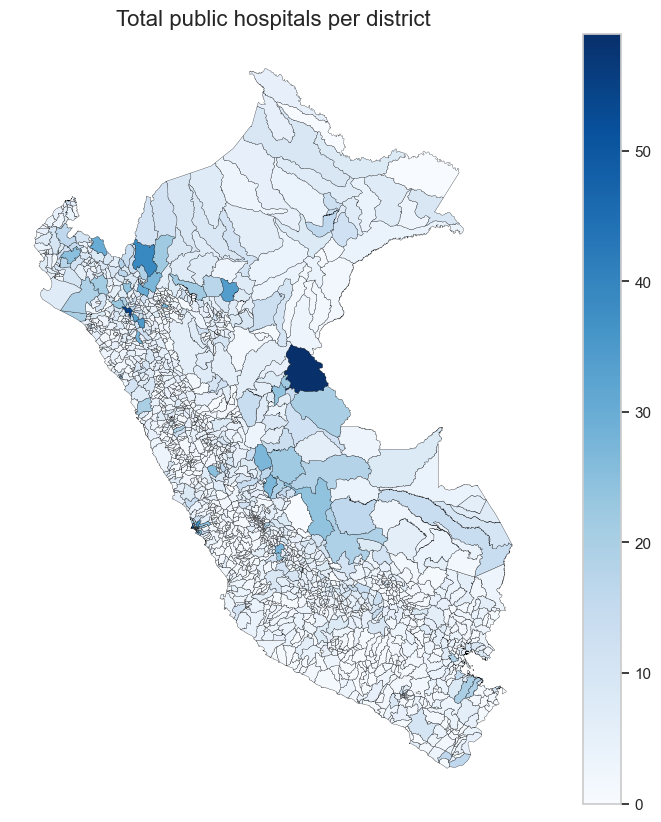

In [275]:
#Total public hospitals per district
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

distritos.plot(
    column="hospital_count",
    cmap="Blues",
    legend=True,
    linewidth=0.2,
    edgecolor="black",
    ax=ax)

ax.set_title("Total public hospitals per district", fontsize=16)
ax.axis("off")
filename = 'Map 1-Total public hospitals per district.jpg'
output_path = os.path.join(output_folder, filename)
fig.savefig(output_path, dpi=300)

plt.show()

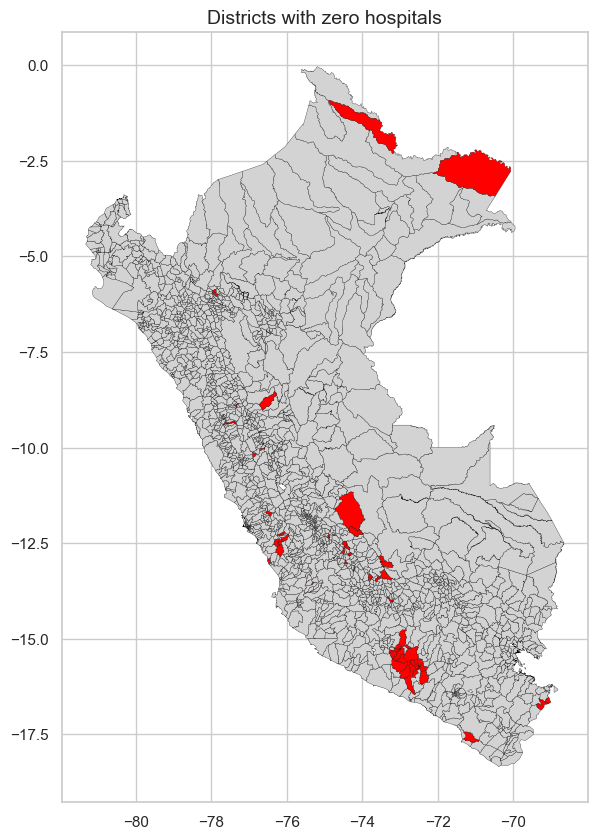

In [276]:
# Districts with zero hospitals
distritos["zero_hosp"] = distritos["hospital_count"] == 0

cmap = mcolors.ListedColormap(['lightgrey', 'red'])
fig, ax = plt.subplots(figsize=(12, 10))
distritos.plot(
    column="zero_hosp",
    cmap=cmap,
    legend=False,  # Optional: legend can be added manually
    linewidth=0.2,
    edgecolor="black",
    ax=ax)
ax.set_title("Districts with Zero Hospitals", fontsize=16)
plt.title("Districts with zero hospitals", fontsize=14)
filename = 'Map 2-Highlight districts with zero hospitals.jpg'
output_path = os.path.join(output_folder, filename)
fig.savefig(output_path, dpi=300)
plt.show()

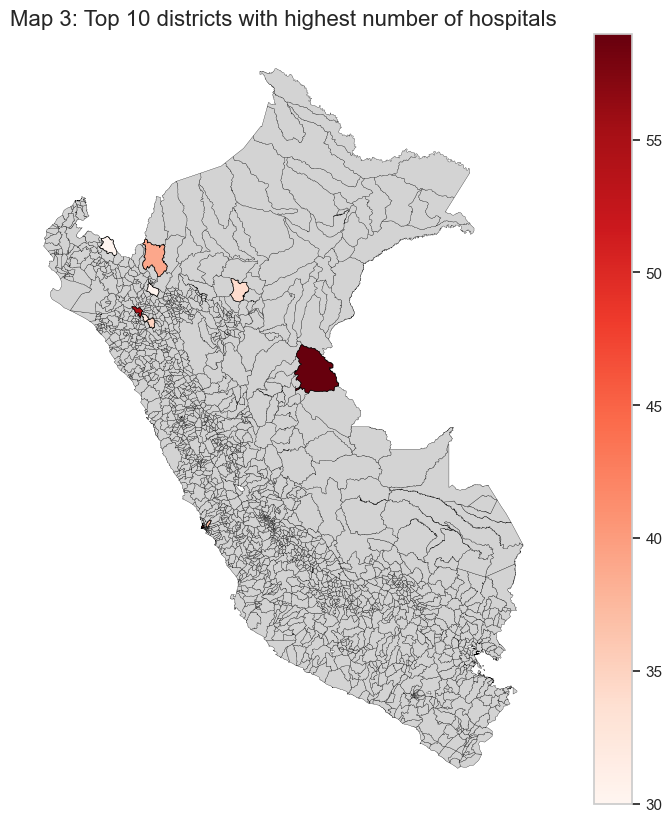

In [277]:
# Top 10 districts with the highest number of hospitals (distinct color scale).

top10_districts = distritos.nlargest(10, 'hospital_count')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

distritos.plot(color='lightgray', linewidth=0.2, edgecolor='black', ax=ax)

top10_districts.plot(column='hospital_count', cmap='Reds', linewidth=0.5, edgecolor='black', legend=True, ax=ax)

ax.set_title("Map 3: Top 10 districts with highest number of hospitals", fontsize=16)
ax.axis("off")

filename = "Map 3-Top 10 districts with highest number of hospitals.jpg"
output_path = os.path.join(output_folder, filename)
fig.savefig(output_path, dpi=300)

plt.show()

Task 2: Department-level Analysis

In [278]:
distritos['DEPARTAMEN'].unique() #We check the departments.

array(['HUANUCO', 'UCAYALI', 'LORETO', 'LA LIBERTAD', 'CAJAMARCA',
       'TACNA', 'MOQUEGUA', 'AREQUIPA', 'PUNO', 'APURIMAC', 'ANCASH',
       'CUSCO', 'ICA', 'SAN MARTIN', 'LAMBAYEQUE', 'HUANCAVELICA',
       'PASCO', 'AMAZONAS', 'LIMA', 'JUNIN', 'MADRE DE DIOS', 'AYACUCHO',
       'CALLAO', 'TUMBES', 'PIURA'], dtype=object)

Hospitales por departamento

In [279]:
hospitals_by_dept = distritos.groupby('DEPARTAMEN')['hospital_count'].sum().reset_index() #We calculate the hospital count per "DEPARTMEN".


In [280]:
hospitals_by_dept_sorted = hospitals_by_dept.sort_values(by='hospital_count', ascending=False)
print("Summary table (Highest to Lowest):\n", hospitals_by_dept_sorted)

Summary table (Highest to Lowest):
        DEPARTAMEN  hospital_count
5       CAJAMARCA             845
14           LIMA             774
11          JUNIN             445
19          PIURA             442
0        AMAZONAS             417
1          ANCASH             416
20           PUNO             407
4        AYACUCHO             387
21     SAN MARTIN             379
2        APURIMAC             375
15         LORETO             351
7           CUSCO             339
12    LA LIBERTAD             336
8    HUANCAVELICA             325
9         HUANUCO             261
18          PASCO             258
24        UCAYALI             234
3        AREQUIPA             224
13     LAMBAYEQUE             181
10            ICA             146
6          CALLAO              97
22          TACNA              79
16  MADRE DE DIOS              66
17       MOQUEGUA              56
23         TUMBES              54


The department with the highest number of hospitals is Cajamarca.

The department with the lowest number of hospitals is Tumbes.

Bar chart

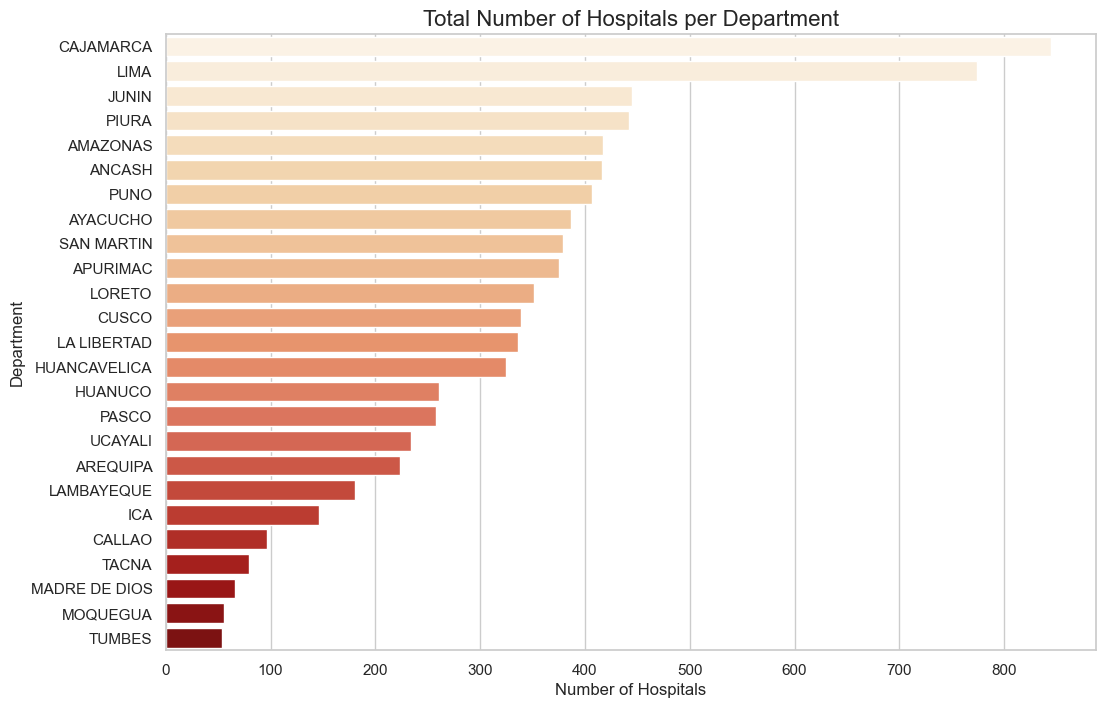

In [281]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.barplot(
    x='hospital_count',
    y='DEPARTAMEN',
    data=hospitals_by_dept_sorted,
    palette="OrRd",
    dodge=False,
    hue='DEPARTAMEN',  
    legend=False        
)
plt.title('Total Number of Hospitals per Department', fontsize=16)
plt.xlabel('Number of Hospitals')
plt.ylabel('Department')
filename = 'Bar chart'
output_path = os.path.join(output_folder, filename)
fig.savefig(output_path, dpi=300)
plt.show()

Department-level choropleth map

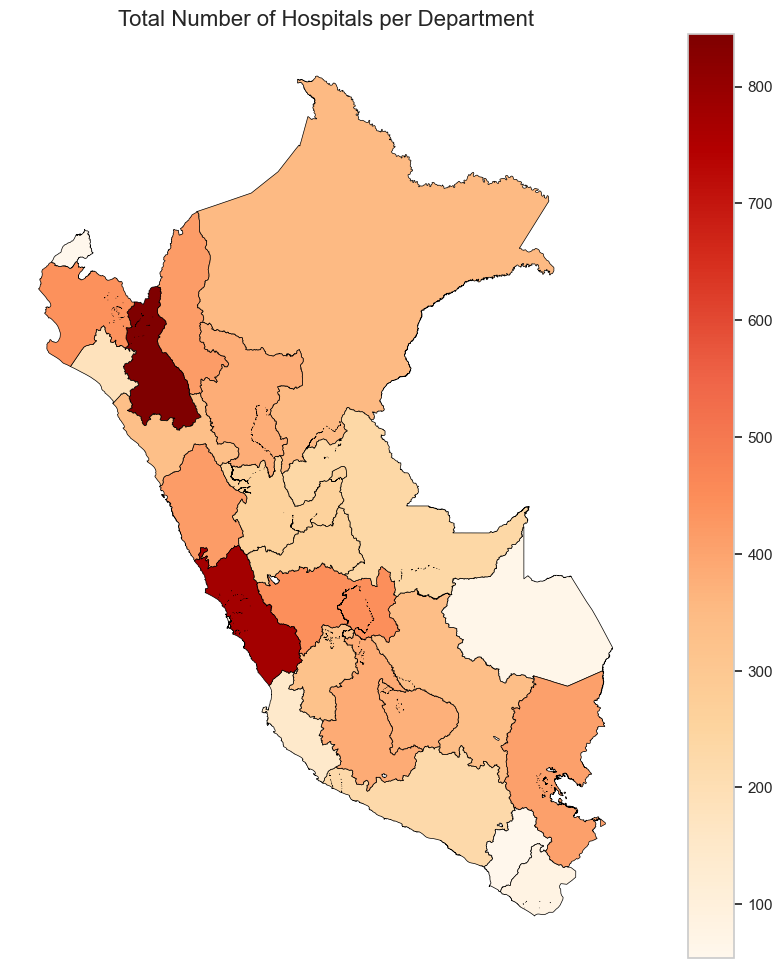

In [282]:
dept_geo = distritos.dissolve(by='DEPARTAMEN', aggfunc='sum').reset_index()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
dept_geo.plot(column='hospital_count', 
              cmap='OrRd', 
              legend=True, 
              edgecolor='black', 
              linewidth=0.5,
              ax=ax)
ax.set_title('Total Number of Hospitals per Department', fontsize=16)
ax.axis('off')

filename = 'Department level choropleth map'
output_path = os.path.join(output_folder, filename)
fig.savefig(output_path, dpi=300)

plt.show()